In [1]:
import astropy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
import scipy as sp
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import Galactocentric as gc

In [2]:
''' Provide number of samples, and scale factors here'''
nsamples = 100
Rd = 2.32           # in kpc
zd = 0.95           # in kpc

In [3]:
def r_prob(r, Rd):
    return (r/(Rd**2))*np.e**(-r/Rd)
def z_prob(z, zd):
    return np.e**(-np.abs(z)/zd) / zd

In [4]:
def draw_samples(func, scale, xmin, xmax, nsamples):
    x = np.linspace(xmin, xmax, 100)
    cdf = lambda xprime : sp.integrate.quad(func, xmin, xprime, args = (scale))[0]
    cdf = np.vectorize(cdf)
    #return cdf(x)
    #return 1
    inv_cdf = sp.interpolate.CubicSpline(cdf(x), x)
    p_values = np.random.uniform(0,1, nsamples)
    samples = inv_cdf(p_values)
    return samples

In [5]:
r_samples = draw_samples(r_prob, Rd, 0, 15, nsamples)
#plt.hist(r_samples, bins = 100, density = True)

In [6]:
zminus_samples = draw_samples(z_prob, zd, -5, 0, int(nsamples/2))
zplus_samples = draw_samples(z_prob, zd, 0, 5, int(nsamples/2))
z_samples = np.concatenate((zminus_samples, zplus_samples))
#plt.hist(z_samples, bins = 100, density = True)

In [7]:
phi_samples = np.random.uniform(0, 2*np.pi, nsamples)

In [8]:
x_samples = r_samples*np.cos(phi_samples)

In [9]:
#plt.scatter(x_samples, z_samples, s = 0.1 , c = 'white')
#plt.grid()
#plt.xlim(-20, 20)
#plt.ylim(-20, 20)
#plt.style.use("dark_background")

In [10]:
sample_coord_cylindrical = coord.SkyCoord(rho= r_samples * u.kpc,
                   phi= phi_samples * u.rad,
                   z= z_samples * u.kpc,
                   frame=coord.Galactocentric, representation_type = 'cylindrical')
sample_coord_icrs = sample_coord_cylindrical.transform_to(coord.ICRS) 

In [11]:
ra_samples = sample_coord_icrs.ra.radian
ra_samples_wrapped = sample_coord_icrs.ra.wrap_at(180 * u.deg).radian ## plotting airoff projections requires a wrap around
dec_samples = sample_coord_icrs.dec.radian
dis_samples = sample_coord_icrs.distance.kpc

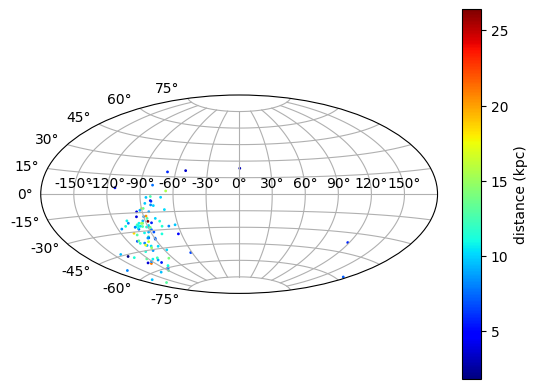

In [12]:

plt.subplot(111, projection="aitoff")
plt.grid()
plt.scatter(ra_samples_wrapped, dec_samples, s= 1, c = dis_samples, cmap = cm.jet)
plt.colorbar(label = 'distance (kpc)')
#plt.subplots_adjust(top=0.95,bottom=0.0)
#plt.figure(dpi = 300)
#plt.savefig('galaxy_sim500.png', dpi = 300)

In [13]:
with h5py.File('sky_loc.hdf', 'w') as hf:
    hf.create_dataset('ra', data = ra_samples)
    hf.create_dataset('dec', data = dec_samples)
    hf.create_dataset('distance', data = dis_samples)